In [1]:
# Qiskit - circuitos
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
# Qiskit - simulaciones
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
# Qiskit - simulaciones con ruido
from qiskit_ibm_runtime import QiskitRuntimeService

from scipy.optimize import minimize # Minimizador
from numpy.typing import NDArray # type annotation

# Elementos de matriz y funciones personalizadas
from H2.elementos_matriz import *
from H2.graficar import plt, graficarVQE

## Métodos clásicos

In [2]:
# cargar elementos de matriz previamente calculados
distancias, h11, h22, J11, J22, J12, K12, hnuc = elementos_H2('cargar')

Elementos de matriz y distancias interatómicas cargadas.


In [3]:
RHF: NDArray[float] = cargar('H2_STO3G_RHF1') # Energía Hartree-Fock restringida
UHF: NDArray[float] = cargar('H2_STO3G_UHF1') # Energía Hartree-Fock sin restricción
CI: NDArray[float] = cargar('H2_STO3G_CI1') # Energía CI

## Variational Quantum Eigensolver (VQE)

In [4]:
def H2_Hamiltoniano_JW(f11: float, f33: float, g1212: float, g3434: float, g1313: float, g1331: float) -> SparsePauliOp:
    """ Hamiltoniano de la molécula de hidrógeno H2 mediante la transformación de Jordan-Wigner (JW)

    Parámetros
        f11 : integral h11
        f33 : integral h22
        g1212 : integral J11
        g3434 : integral J22
        g1313 : integral J12
        g1331 : integral K12
    """
    h12: float = (2*f11 + g1212 + 2*g1313 - g1331)/4
    h34: float = (2*f33 + g3434 + 2*g1313 - g1331)/4
    h0: float = f11 + f33 + g1212/4 + g3434/4 + g1313 - g1331/2
    
    hamiltoniano = SparsePauliOp.from_list(
        [
            ("IIII", h0),
            ("IIIZ", -h12), ("IZII", -h12),
            ("IIZI", -h34), ("ZIII", -h34),
            ("IZIZ", g1212/4),
            ("IIZZ", (g1313-g1331)/4), ("ZZII", (g1313-g1331)/4),
            ("ZIIZ", g1313/4), ("XYXY", g1331/4),
            ("XYYX", -g1331/4), ("YXXY", -g1331/4),
            ("YXYX", g1331/4), ("IZZI", g1313/4),
            ("ZIZI", g3434/4),
        ]
    )
    return hamiltoniano

In [5]:
# creación del problema
num_orbitales_espaciales  = 2 # dos orbitales espaciales (ligante y antiligante)
num_particulas  = (1,1) # una partícula con espín arriba y otra con espín abajo
mapeo_qubit  = JordanWignerMapper() # mapeo de qubits

# Estimador
estimator = Estimator()

In [6]:
def funcion_costo(params:NDArray, ansatz_isa: QuantumCircuit, hamiltonian: SparsePauliOp, estimator: Estimator):
    """ Regresa el estimado de energía a partir del estimador

    Parámetros
        params: Arreglo de parámetros del ansatz
        ansatz_isa: Circuito ansatz parametrizado
        hamiltonian: Representación operacional del Hamiltoniano
        estimator: Instancia de la primitiva estimador

    Devuelve
        float: Estimación de energía
    """

    pub = (ansatz_isa, hamiltonian, [params])
    job = estimator.run([pub])
    resultado = job.result()
    pub_result = resultado[0]

    cost = pub_result.data.evs[0]
    return cost

In [7]:
def VQE(i: int, backend: str=None, optimization_level: int=2, params_inicial: NDArray=None) -> list[float]:
    """ Variational Quantum Eigensolver

    Parámetros
        i: índice del elemento
        backend:
        optimization_level: 
        params_inicial : 

    Devuelve:
        params_optimizados: parámetros optimizados
        energia_total: valor de la energía total
    """

    # (1) Estado inicial
    edo_inicial = HartreeFock(num_orbitales_espaciales, num_particulas, mapeo_qubit)
    # (2.1) Ansatz
    ansatz = UCCSD(num_orbitales_espaciales, num_particulas, mapeo_qubit, initial_state=edo_inicial)
    # (2.2) Parámetros iniciales del ansatz
    if params_inicial is None:
        num_params = ansatz.num_parameters # número de parámetros T_i en el ansatz
        params_inicial = [0] * num_params # parámetros iniciales (todos cero)
    else:
        params_inicial = params_inicial # parámetros iniciales
    # (3) Hamiltoniano
    hamiltonian_isa = H2_Hamiltoniano_JW(h11[i], h22[i], J11[i], J22[i], J12[i], K12[i])
    
    # Simulador
    aer = AerSimulator()

    # Pass Manager
    pass_manager = generate_preset_pass_manager(backend=aer, optimization_level=optimization_level)
    ansatz_isa = pass_manager.run(ansatz)
    
    # Minimización
    energia_vqe = minimize(funcion_costo, params_inicial, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
    params_optimizados = energia_vqe.x # parámetros optimizados

    # Resultado
    energia_total = energia_vqe.fun + hnuc[i] # energía total

    return params_optimizados, energia_total

### VQE sin ruido

In [8]:
%%time
print("VQE - optimización máxima - sin ruido\n")
params_optimizados, energia_VQE = [], []

total: int = len(distancias)
counter: int = 10
for i in range(total):
    # Parámetros iniciales.
    ## La iteración i+1 considera como parámetros iniciales los parámetros optimizados de la i-ésima iteración
    ## Como cada iteración corresponde a una distancia interatómica R distinta para H2
    ## La energía para la i-ésima R, si bien no es igual que la anterior, es muy similar
    ## Así que los parámetros serán semajantes
    params_inicial = params_optimizados[i-1] if (i != 0) else None
    
    # VQE, optimización máxima, sin ruido
    params, energia = VQE(i, None, 3, params_inicial)
    params_optimizados.append(params)
    energia_VQE.append(energia)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

VQE - optimización máxima - sin ruido

10% de casos calculados. 29 de 299.
20% de casos calculados. 59 de 299.
30% de casos calculados. 89 de 299.
40% de casos calculados. 119 de 299.
50% de casos calculados. 149 de 299.
60% de casos calculados. 178 de 299.
70% de casos calculados. 208 de 299.
80% de casos calculados. 238 de 299.
90% de casos calculados. 268 de 299.
100% de casos calculados. 298 de 299.
CPU times: user 5min 20s, sys: 7.34 s, total: 5min 28s
Wall time: 5min 48s


In [9]:
# Guardar el conjunto de datos calculado en la celda previa
guardar('H2_VQE', energia_VQE)

In [10]:
# Valores de la energía en función de la distancia interatómica reportada por Kandala, et. al.
x_Kandala = np.array([0.204,0.299,0.401,0.591,0.73,0.985,1.19,1.387,1.577,1.788,1.978,2.985,3.974]) # distancia interatómica (Angstroms)
y_Kandala = np.array([0.194,-0.536,-0.848,-1.076,-1.109,-1.061,-1.039,-1.006,-0.979,-0.921,-0.936,-0.924,-0.927]) # energía (hartrees)

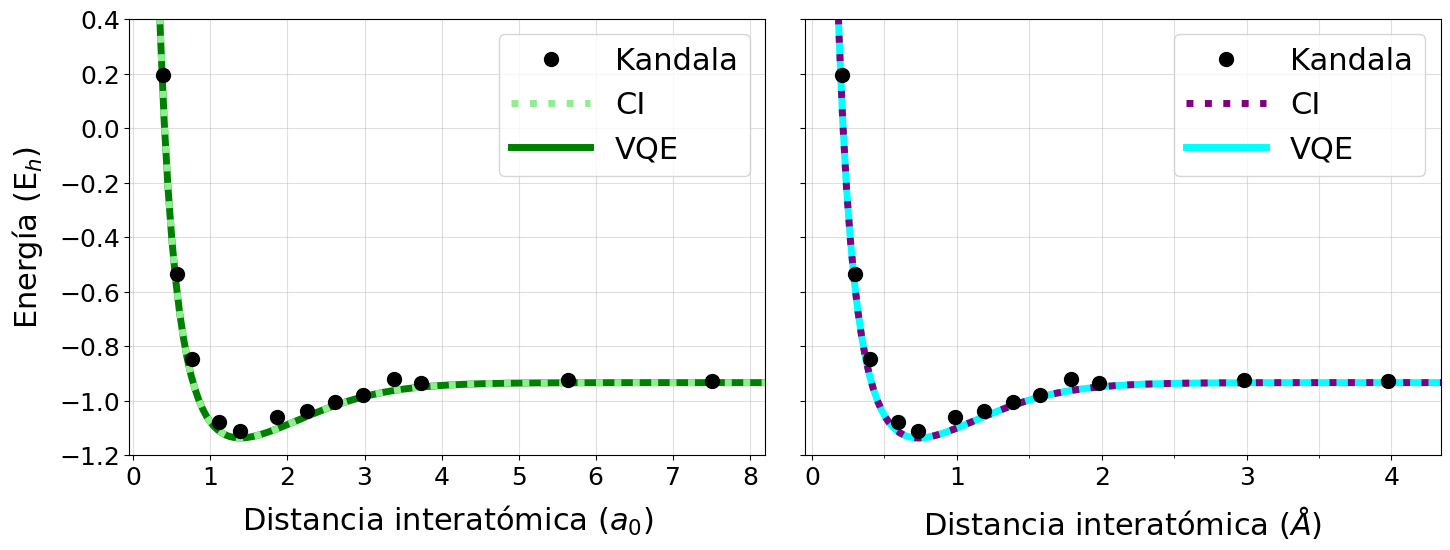

In [11]:
# Graficar resultados
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 fila, 1 columnas, tamaño de figura (15, 5)
linewidth, fontsize, labelsize, alpha = 5, 22, 18, 0.4

factor = 0.529177249 # unidades atómicas de distancia a Angstroms
xmin, xmax = -0.05, 8.2

###################
### Gráfica derecha
###################
# axs[0].plot(distancias, UHF, linewidth=linewidth, linestyle='dashed', label='UHF', color='blue')
# axs[0].plot(distancias, RHF, linewidth=linewidth, linestyle='dotted', label='RHF', color='green')
axs[0].plot(distancias, energia_VQE, linewidth=linewidth, linestyle='solid', label='VQE', color='green')
axs[0].plot(distancias, CI, linewidth=linewidth, linestyle='dotted', label='CI', color='lightgreen')
axs[0].plot(x_Kandala/factor, y_Kandala, linewidth=None, linestyle='None', label='Kandala', color='black', marker='o', markersize=10)
# x config
axs[0].set_xticks(np.arange(0, 9, 1))
axs[0].set_xlim(xmin, xmax)
axs[0].set_xlabel(r'Distancia interatómica ($a_0$)', fontsize=fontsize, labelpad=10)
# y config
axs[0].set_ylim(-1.2,0.4)
axs[0].set_ylabel(r'Energía ($\mathrm{E}_h$)', fontsize=fontsize, labelpad=10)
# plot config
handles, labels = axs[0].get_legend_handles_labels()
order = [2,1,0]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fontsize, handlelength=2.6)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].grid(alpha=alpha)

#####################
### Gráfica izquierda
#####################
# axs[1].plot(distancias*factor, UHF, linewidth=linewidth, linestyle='dashed', label='UHF', color='orange')
# axs[0].plot(distancias, RHF, linewidth=linewidth, linestyle='dotted', label='RHF', color='green')
axs[1].plot(distancias*factor, energia_VQE, linewidth=linewidth, linestyle='solid', label='VQE', color='cyan')
axs[1].plot(distancias*factor, CI, linewidth=linewidth, linestyle='dotted', label='CI', color='purple')
axs[1].plot(x_Kandala, y_Kandala, linewidth=None, linestyle='None', label='Kandala', color='black', marker='o', markersize=10)
# x config
axs[1].set_xticks(np.arange(0, 5, 1))
axs[1].set_xticks(np.arange(0, 5, 0.5), minor=True)
axs[1].set_xlim(xmin, xmax*factor)
axs[1].set_xlabel(r'Distancia interatómica ($\AA$)', fontsize=fontsize, labelpad=10)
# y config
axs[1].set_yticks(np.arange(-1.4, 0.5, 0.2), minor=True)
axs[1].set_ylim(-1.2, 0.4)
axs[1].set(yticklabels=[])
# plot config
handles, labels = axs[1].get_legend_handles_labels()
order = [2,1,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=fontsize, handlelength=2.6)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].grid(alpha=alpha, which='both')

fig.tight_layout(pad=2.5)
plt.show()
# fig.savefig('imgs/H2_VQE.svg', format='svg', bbox_inches='tight')

In [12]:
t0: list[np.float64] = [params[0] for params in params_optimizados]
t1: list[np.float64] = [params[1] for params in params_optimizados]
t2: list[np.float64] = [params[2] for params in params_optimizados]

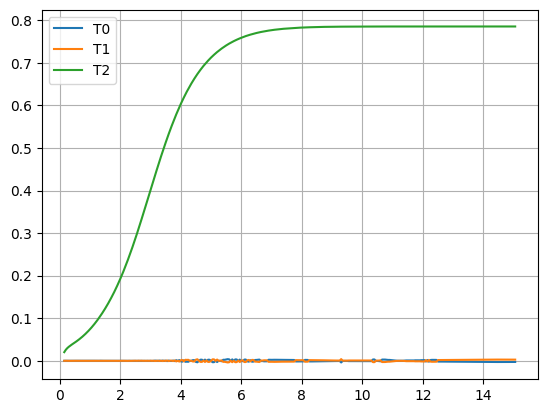

In [13]:
plt.plot(distancias, t0, label="T0")
plt.plot(distancias, t1, label="T1")
plt.plot(distancias, t2, label="T2")
# plt.plot(distances, energia_VQE)
plt.legend()
plt.grid()
plt.show()

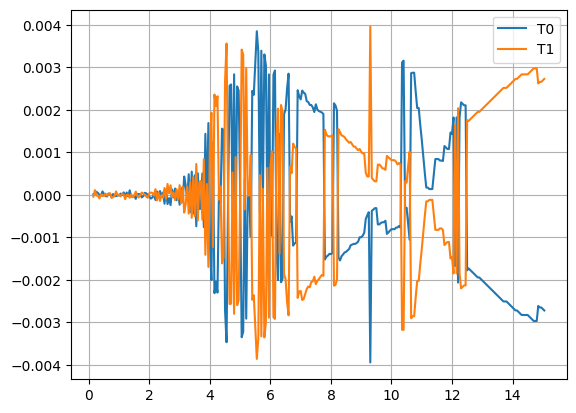

In [14]:
plt.plot(distancias, t0, label="T0")
plt.plot(distancias, t1, label="T1")
# plt.plot(distances, energia_VQE)
plt.legend()
plt.grid()
plt.show()